# Import of libraries and files

In [1]:
import pandas as pd
import numpy as np
import os
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from collections import Counter
import string
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score
from sklearn.pipeline import make_pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix
import joblib
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.models import Sequential, load_model
from keras.layers import Dense, Embedding, LSTM, Bidirectional
from keras.callbacks import EarlyStopping, ModelCheckpoint
import h5py
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
import ndjson
import json

from src.process_ndjson_to_json import process_ndjson_to_json
from src.preprocess_texts import preprocess_texts
from src.load_build_embeddings import load_embeddings, build_matrix
from src.build_evaluate_nn import build_nn_with_embeddings, evaluate_nn
from src.plot_accuracy_loss import plot_accuracy, plot_loss
from src.plot_confusion_matrix import plot_confusion_matrix

Using TensorFlow backend.


In [3]:
# data is in new line delimited json format so I use ndjson library to open it
ndjson_file = 'data/raw/data.json'
json_file = 'data/processed/data_final.json'

In [0]:
data_json = process_ndjson_to_json(ndjson_file, json_file)

In [4]:
data = pd.read_json(json_file, orient="records")

In [0]:
data.head()

,headline,is_sarcastic
0,former versace store clerk sues over secret 'b...,0
1,the 'roseanne' revival catches up to our thorn...,0
2,mom starting to fear son's web series closest ...,1
3,"boehner just wants wife to listen, not come up...",1
4,j.k. rowling wishes snape happy birthday in th...,0


In [0]:
print(f'There are {data.shape[0]} headlines')

There are 26709 headlines


In [0]:
# checking number of sarcastic and non-sarcastic comments
data['is_sarcastic'].value_counts()/len(data)

0    0.561047
1    0.438953
Name: is_sarcastic, dtype: float64

Classes are rather balanced so accuracy can be used as classification metric.

# Assigning variables

In [5]:
X = data["headline"]
y = data["is_sarcastic"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, 
                                                          random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.15, 
                                                          random_state=52)

# 1st approach: Naive Bayes

Naive Bayes is a simple classifier which is often used in NLP tasks like spam detection. Even though one of its assumptions (independency between words) is actually almost never fulfilled it still scores well. I will try how it copes with sarcasm detection.

For vectorization I will use Tf-idf Vectorizer which attaches high weight to words rare in a document collection but frequent in a particular document, such words are discriminative for documents.

In [26]:
model = make_pipeline(TfidfVectorizer(), MultinomialNB())
model.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('tfidfvectorizer', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.float64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth...   vocabulary=None)), ('multinomialnb', MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))])

In [27]:
print(f'Accuracy on train set: {accuracy_score(y_train, model.predict(X_train))}')
print(f'Accuracy on validation set: {accuracy_score(y_val, model.predict(X_val))}')

Accuracy on train set: 0.9156301824212272
Accuracy on validation set: 0.8206106870229007


The score 82% on validation set is a decent one. Let's check if more complicated approach gives better results.

# 2nd approach: pretrained Embeddings + LSTM

Second approach should be more powerful as it includes word embeddings (vectorized reprezentation of words based on their context and relationship between words compared to tf_idf matrix which is based on frequencies only) and LSTM neural network, which can "remember" context (words that were before).

## Text preprocessing for LSTM

In [6]:
# tokenizing and filtering out basic punctuation
# I won't turn words to lowercase as I will use cased GloVe embeddings
# so that "Bush" can have a different embedding from "bush"
tokenizer = Tokenizer(lower=False)
tokenizer.fit_on_texts(X_train)

# dictionary mapping words (str) to their index (int)
word_index = tokenizer.word_index
print(f"Found {len(word_index)} unique tokens.")

# turning texts into sequences (list of word indices)
sequences_train = tokenizer.texts_to_sequences(X_train)
sequences_test = tokenizer.texts_to_sequences(X_test)
sequences_val = tokenizer.texts_to_sequences(X_val)

# checking the length of the longest headline
max_len = max([len(x) for x in sequences_train+sequences_val+sequences_test])
print(f"The longest headline has {max_len} words.")

# padding sequences so that they are of equal length
X_train_nn = sequence.pad_sequences(sequences_train, max_len)
X_test_nn = sequence.pad_sequences(sequences_test, max_len)
X_val_nn = sequence.pad_sequences(sequences_val, max_len)

Found 25218 unique tokens.
The longest headline has 40 words.


## Loading and filtering embeddings

Almost 27 000 headlines don't seem enough data to train powerful word-embeddings on them. I will use pre-trained GloVe embedings trained on Common Crawl corpus with 840B tokens and 2.2M vocab, cased. I will load it from a pickled file saved locally (3GB) and filter out the embeddings for the words in my vocab.

In [ ]:
emb_matrix, unknown_words = build_matrix(word_index, path_to_embeddings)

In [0]:
# saving matrix with filtered embeddings 
joblib.dump(emb_matrix, "/data/processed/emb_matrix.joblib")

In [0]:
print('% of unknown words: ', len(unknown_words)/len(word_index))

% of unknown words:  0.1823300816876834


Only less than 20% of words don't have embedding, that's a promising output.

In [7]:
# loading matrix with filtered embeddings
emb_matrix = joblib.load('/data/processed/emb_matrix.joblib')

FileNotFoundError: [Errno 2] No such file or directory: '/data/processed/emb_matrix.joblib'

## Training NN

Preprocessed texts and embeddings can be fed into Neural Network. I test several different architectures basing on LSTM.

In [0]:
def build_lstm_model(list_of_layers):
  
  model = Sequential()
  model.add(Embedding(emb_matrix.shape[0],
                      emb_matrix.shape[1], 
                      input_length=max_len,
                      weights = [emb_matrix], 
                      trainable = False))
  for layer in list_of_layers:
    model.add(layer)
  model.summary() 
  
  model.compile(loss="binary_crossentropy",
               optimizer="adam", 
               metrics=["binary_accuracy"])
  return model

In [0]:
def evaluate_lstm_model(model, X_train, X_val, y_train, y_val, filename, batch_size=32, early_stopping=False):

  take_best_model = ModelCheckpoint(str(filename)+".h5py", save_best_only=True)
  
  if early_stopping == True:
    early_stopping = EarlyStopping(patience=10, monitor="val_loss")
    history = model.fit(X_train, y_train, epochs=50, validation_split=0.2,
              batch_size=batch_size, 
              callbacks=[early_stopping, take_best_model])
   
  else:
    history = model.fit(X_train, y_train, epochs=50, validation_split=0.2,
              batch_size=batch_size, 
              callbacks=[take_best_model])
  
  joblib.dump(history, filename)

  model.load_weights(str(filename)+".h5py")
  return model.evaluate(X_val, y_val)[1]

Following architectures might be too extensive for the given problem but first I want to check if they overfit and if they do, I will prune them.

In [0]:
models = {        
          "LSTM_200_100_50":      [LSTM(200, return_sequences=True),
                             LSTM(100, return_sequences=True),
                             LSTM(50),
                                  Dense(1, activation="sigmoid")],
          
          "BiLSTM_100_50":          [Bidirectional(LSTM(100, return_sequences=True)),
                                     Bidirectional(LSTM(50)),
                                  Dense(1, activation="sigmoid")],
          
          "LSTM_200_100":    [LSTM(200, return_sequences=True),
                                  LSTM(100),
                                  Dense(1, activation="sigmoid")]
}

Training models for 50 epochs:

In [0]:
# building and evaluating models using functions from build_evaluate_nn module
lst = []
for model, params in models.items():
  acc = (evaluate_nn(build_nn(params), X_train_nn, X_val_nn, y_train, y_val, model, early_stopping=False))
  lst.append(acc)

In [0]:
# printing accuracy of models
model_results = pd.DataFrame(list(zip(models.keys(), lst)), columns=["model", "accuracy_val"]).sort_values(by="accuracy_val", ascending=False).reset_index(drop=True)

In [0]:
model_results

,model,accuracy_val
0,LSTM_200_100,0.868761
1,BiLSTM_100_50,0.863770
2,LSTM_200_100_50,0.858485


The differences between models' accuracy on validation set are rather small with the simplest model having the highest score. This may be indicative of overfitting. Let's check by plotting accuracy and loss during training.

In [0]:
def plot_accuracy(path, models):
  '''Function to plot accuracy on train and validation sets.'''
  for model in models:
    history = joblib.load(os.path.join(path_to_results, model))
    plt.plot(history.history['binary_accuracy'])
    plt.plot(history.history['val_binary_accuracy'])
    plt.title(f"model {model} accuracy")
    plt.ylabel('accuracy')
    plt.ylim(0.6, 1)
    plt.xlabel('epoch')
    plt.legend(['train', 'valid'], loc='upper left')
    plt.show()

In [0]:
def plot_loss(path, models):
  '''Function to plot loss on train and validation sets.'''
  for model in models:
    history = joblib.load(os.path.join(path_to_results, model))
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title(f"model {model} loss")
    plt.ylabel('loss')
    #plt.ylim(0.6, 1)
    plt.xlabel('epoch')
    plt.legend(['train', 'valid'], loc='upper left')
    plt.show()

In [0]:
# plotting accuracy of models for train and validation sets using plot_accuracy_loss module
path_to_results = "/content/gdrive/My Drive/zadanie_Roche/models" # to remove!!!
#path_to_results = "/models"
plot_accuracy(path_to_results, models)

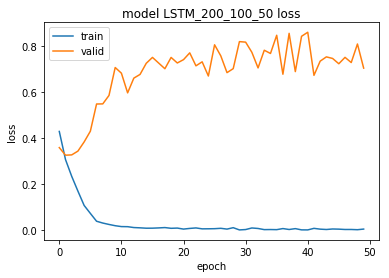

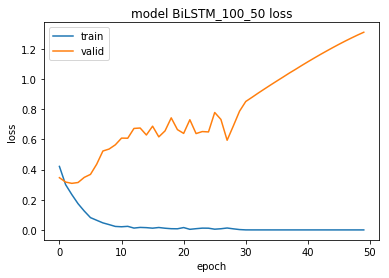

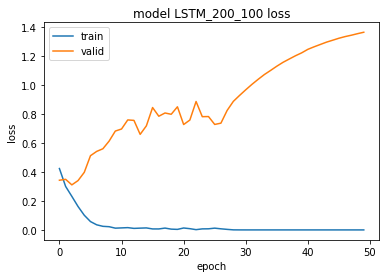

In [0]:
plot_loss(path_to_results, models)

Plots of accuracy and loss suggest that models are heavily overfitted. Accuracy on the train set was raising until it reached 100%, wheras the accuracy on the validation set was almost constant. There was also a huge discrepancy between loss on train set and validation set with the latter one even sharply rising for the last two models after ca. 25 epoch. The architectures are probably too big for the problem at hand and 50 epochs seems to be too long a training. So I will prune the networks and add Early Stopping callback, so that the network stops learning when the loss on validation set isn't falling anymore.

In [0]:
models = {        
          "LSTM_100n":      [LSTM(100),
                                  Dense(1, activation="sigmoid")],
          
          "BiLSTM_50n":          [Bidirectional(LSTM(50)),
                                  Dense(1, activation="sigmoid")],
          
          "LSTM_50n_30n":    [LSTM(50, return_sequences=True),
                                  LSTM(30),
                                  Dense(1, activation="sigmoid")],
                                        
          "LSTM_MultipleDense":     [LSTM(100),
                                  Dense(30, activation="relu"),
                                  Dense(1, activation="sigmoid")]
}

W0618 08:46:27.337060 140220677252992 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.



In [0]:
# building and evaluating models using functions from build_evaluate_nn module
lst = []
for model, params in models.items():
  acc = (evaluate_nn(build_nn(emb_matrix, max_len, params), X_train_nn, X_val_nn, y_train, y_val, model, early_stopping=True))
  lst.append(acc)

In [0]:
# building and evaluating models using functions from build_evaluate_nn module
# to remove
lst = []
for model, params in models.items():
  acc = (evaluate_lstm_model(build_lstm_model(params), X_train_nn, X_val_nn, y_train, y_val, model, early_stopping=True))
  lst.append(acc)

W0618 08:49:33.570064 140220677252992 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0618 08:49:33.584057 140220677252992 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0618 08:49:33.596623 140220677252992 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0618 08:49:33.597509 140220677252992 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:181: The name tf.ConfigProto is deprecated. Please use tf.compat.v1.ConfigProto instead.

W0618 08:49:36.639364 140220677252992 depre

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 40, 300)           7565400   
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               160400    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
Total params: 7,725,901
Trainable params: 160,501
Non-trainable params: 7,565,400
_________________________________________________________________
Train on 15436 samples, validate on 3860 samples
Epoch 1/50
15436/15436 [==============================] - 34s 2ms/step - loss: 0.4305 - binary_accuracy: 0.7964 - val_loss: 0.3609 - val_binary_accuracy: 0.8417
Epoch 2/50
15436/15436 [==============================] - 33s 2ms/step - loss: 0.3050 - binary_accuracy: 0.8708 - val_loss: 0.3192 - val_binary_accuracy: 0.8630
Epoch 3/50
15436/15

In [0]:
# printing accuracy of models
model_results = pd.DataFrame(list(zip(models.keys(), lst)), columns=["model", "accuracy_val"]).sort_values(by="accuracy_val", ascending=False).reset_index(drop=True)

In [0]:
model_results

,model,accuracy_val
0,LSTM_MultipleDense,0.864063
1,LSTM_100n,0.863476
2,BiLSTM_50n,0.849090
3,LSTM_50n_30n,0.847622


It turned out that the best model is the simplest one - one LSTM layer with 100 neurons. The model scored only 0.4 percentage points lower than the best of complicated models from the previous run.

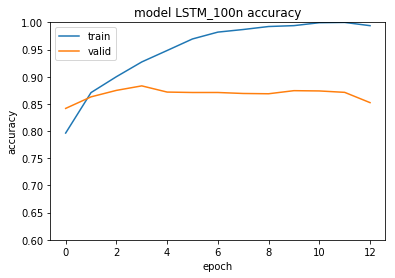

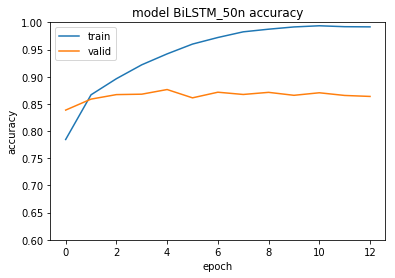

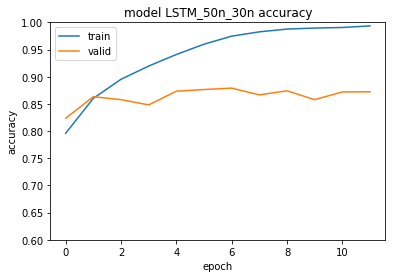

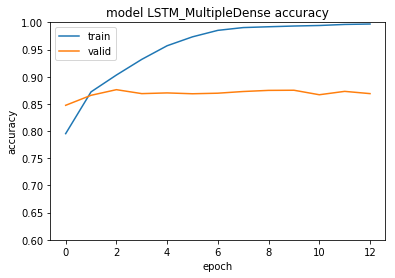

In [0]:
plot_accuracy(path_to_results, models)

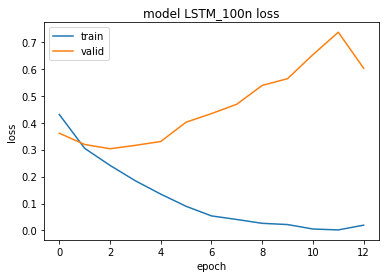

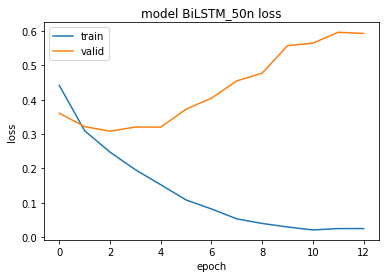

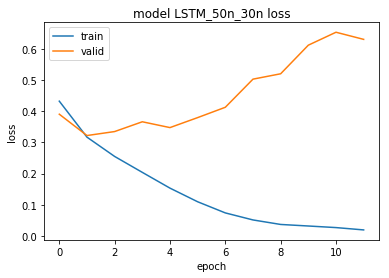

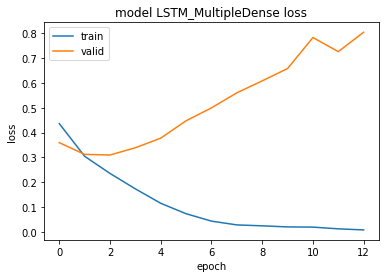

In [0]:
plot_loss(path_to_results, models)

Even after pruning neural nets and applying Early Stopping callback, models seems to be ovefitting as they recognize sarcasm in training set better and better without the ability to improve score on validation set (and validation loss even keeps rising - so if the accuracy of preditions is almost constant that could mean less confidence of the model in the right predictions or more error on the side of wrong predictions).

I will check very simple architectures with few neurons and EarlyStopping.

In [7]:
models = {"LSTM_16n":      [LSTM(16),
                          Dense(1, activation="sigmoid")],
          
          "LSTM_32n":      [LSTM(32),
                          Dense(1, activation="sigmoid")],
          
          "LSTM_64n":      [LSTM(64),
                          Dense(1, activation="sigmoid")]

}

W0619 09:07:25.760479 139735665244032 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.



In [0]:
# building and evaluating models using functions from build_evaluate_nn module
# to remove
lst = []
for model, params in models.items():
  acc = (evaluate_lstm_model(build_lstm_model(params), X_train_nn, X_val_nn, y_train, y_val, model, early_stopping=True))
  lst.append(acc)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_13 (Embedding)     (None, 40, 300)           7565400   
_________________________________________________________________
lstm_20 (LSTM)               (None, 16)                20288     
_________________________________________________________________
dense_16 (Dense)             (None, 1)                 17        
Total params: 7,585,705
Trainable params: 20,305
Non-trainable params: 7,565,400
_________________________________________________________________
Train on 15436 samples, validate on 3860 samples
Epoch 1/50
15436/15436 [==============================] - 42s 3ms/step - loss: 0.4807 - binary_accuracy: 0.7650 - val_loss: 0.3956 - val_binary_accuracy: 0.8210
Epoch 2/50
15436/15436 [==============================] - 33s 2ms/step - loss: 0.3384 - binary_accuracy: 0.8546 - val_loss: 0.3552 - val_binary_accuracy: 0.8459
Epoch 3/50
15436/154

In [0]:
# printing accuracy of models
model_results = pd.DataFrame(list(zip(models.keys(), lst)), columns=["model", "accuracy_val"]).sort_values(by="accuracy_val", ascending=False).reset_index(drop=True)

In [0]:
model_results

,model,accuracy_val
0,LSTM_64n,0.865238
1,LSTM_32n,0.856430
2,LSTM_16n,0.855843


The model with one hidden layer conatining 64 neurons reached a very good score of 86,5% on validation set. 

W0619 09:08:27.326585 139735665244032 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0619 09:08:27.335845 139735665244032 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0619 09:08:27.582457 139735665244032 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0619 09:08:27.583410 139735665244032 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:181: The name tf.ConfigProto is deprecated. Please use tf.compat.v1.ConfigProto instead.

W0619 09:08:30.532223 139735665244032 depre

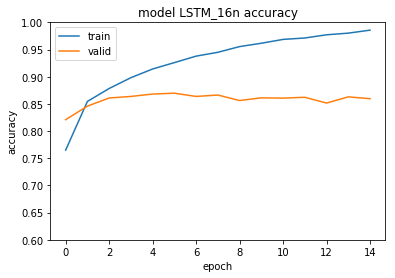

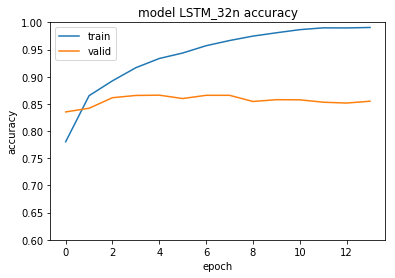

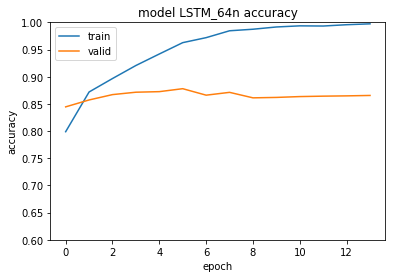

In [10]:
plot_accuracy(path_to_results, models)

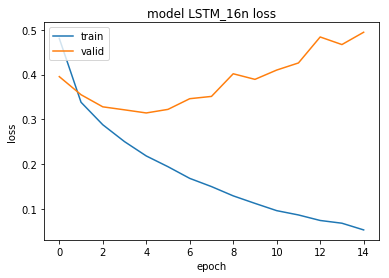

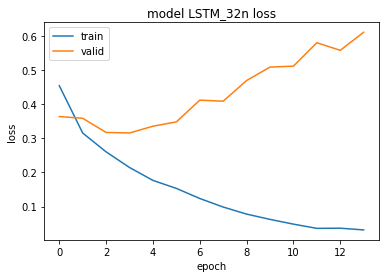

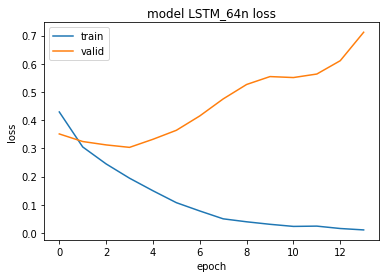

In [11]:
plot_loss(path_to_results, models)

The plots of loss and accuracy follow the same patern as for bigger models. However, I will check best performer in this run: LSTM with 64 neurons on test and treat it as a final model.

# Results on test set

In [22]:
# loading best model from a file and evaluating on test set

best_model = build_lstm_model(models["LSTM_64n"])
best_model.load_weights("/content/gdrive/My Drive/zadanie_Roche/models/LSTM_64n.h5py")
best_model.compile(loss="binary_crossentropy",
               optimizer="adam", 
               metrics=["binary_accuracy"])
best_model_score = best_model.evaluate(X_test_nn, y_test)[1]
print(f"Accuracy of best model: {best_model_score}")
best_model.save("/content/gdrive/My Drive/zadanie_Roche/models/best_model.h5py")

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 40, 300)           7565400   
_________________________________________________________________
lstm_3 (LSTM)                (None, 64)                93440     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 65        
Total params: 7,658,905
Trainable params: 93,505
Non-trainable params: 7,565,400
_________________________________________________________________
4007/4007 [==============================] - 4s 1ms/step
Accuracy of best model: 0.8684801597204892


Even though the plots suggest that the model could be overfitted, it generalized well on the test set with the accuracy of 86,8%. 

In [0]:
best_model = load_model("/content/gdrive/My Drive/zadanie_Roche/models/best_model.h5py")

In [0]:
y_pred_test = best_model.predict_classes(X_test_nn)

In [0]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    Snippet from sklearn docs.
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    #classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

Normalized confusion matrix
[[0.87062 0.12938]
 [0.13429 0.86571]]


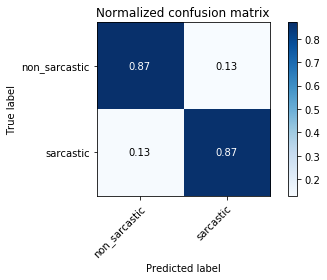

In [50]:
np.set_printoptions(precision=5)
plot_confusion_matrix(y_test, y_pred_test, classes=["non_sarcastic", "sarcastic"], normalize=True,
                      title='Normalized confusion matrix')
plt.show()

87% of both sarcastic and non-sarcastic headlines were classified correctly.